# Hyper Parameter Tuning using RandomizedSearchCV

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './data/prepped_data/'  # Adjusted base path to where our files are now
X_train_path = base_path + 'X_train.csv'
X_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Assuming the last columns of X_train and X_test are year, month, day, hour for reconstructing the datetime index
X_train['datetime'] = pd.to_datetime(X_train[['year', 'month', 'day', 'hour']])
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day', 'hour']])
y_train.index = pd.to_datetime(X_train['datetime'])
y_test.index = pd.to_datetime(X_test['datetime'])

# Exclude non-numerical columns before scaling
columns_to_scale = X_train.columns.difference(['year', 'month', 'day', 'hour', 'datetime'])

# Initialize the scaler for the features
scaler_X = MinMaxScaler()

# Scale 'X' features (excluding non-numerical columns)
X_train_scaled = scaler_X.fit_transform(X_train[columns_to_scale])
X_test_scaled = scaler_X.transform(X_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


## Imports

## Random Search

In [2]:
import numpy as np
import math
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error

# Assuming the following variables are defined and properly prepared:
# X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, scaler_y

n_input = 168  # Number of time steps to look back for predictions
n_features = X_train_scaled.shape[1]  # Number of features in the dataset

def objective(trial):
    # Hyperparameters to be tuned
    units = trial.suggest_categorical('units', [50, 100, 150])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Model definition
    model = Sequential([
        LSTM(units=units, activation=activation, input_shape=(n_input, n_features)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Fit model using TimeseriesGenerator
    train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=batch_size)
    validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=batch_size)
    model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=0)
    
    # Evaluate the model
    val_loss = model.evaluate(validation_generator, verbose=0)
    return val_loss

# Optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

# After optimization, print best parameters
best_params = study.best_trial.params
print(f"Best parameters: {best_params}")

# Correct approach to use the best parameters to create a new model
model = Sequential([
    LSTM(units=best_params['units'], activation=best_params['activation'], input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse')

# It's suggested to retrain our model here with the entire dataset or a combined train-validation set if applicable
# Adjust batch_size based on best_params if it was part of the optimization
train_generator = TimeseriesGenerator(X_train_scaled, y_train_scaled, length=n_input, batch_size=best_params['batch_size'])
model.fit(train_generator, epochs=10, verbose=1)  # Or more epochs as needed

validation_generator = TimeseriesGenerator(X_test_scaled, y_test_scaled, length=n_input, batch_size=best_params['batch_size'])
y_pred_scaled = model.predict(validation_generator)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Define y_pred by inversely transforming the scaled predictions

# Now that y_pred is defined, adjust the length of y_test_original accordingly
y_test_original = y_test.values.flatten()[:len(y_pred)]

# Calculate RMSE and MAPE
rmse = math.sqrt(mean_squared_error(y_test_original, y_pred))
mape = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[I 2024-03-22 13:54:37,204] A new study created in memory with name: no-name-0e7257a5-f9ed-4930-83df-d77143f326ed


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[I 2024-03-22 14:02:57,766] Trial 0 finished with value: 0.00046259554801508784 and parameters: {'units': 100, 'activation': 'tanh', 'learning_rate': 0.0006458114975103095, 'batch_size': 64}. Best is trial 0 with value: 0.00046259554801508784.
[I 2024-03-22 14:14:50,623] Trial 1 finished with value: 0.004167140927165747 and parameters: {'units': 150, 'activation': 'relu', 'learning_rate': 0.0013068160626799614, 'batch_size': 64}. Best is trial 0 with value: 0.00046259554801508784.
[I 2024-03-22 14:18:27,707] Trial 2 finished with value: 0.014332489110529423 and parameters: {'units': 50, 'activation': 'relu', 'learning_rate': 0.0007281418573712064, 'batch_size': 128}. Best is trial 0 with value: 0.00046259554801508784.
[I 2024-03-22 14:22:27,181] Trial 3 finished with value: 0.012172671966254711 and parameters: {'units': 50, 'activation': 'relu', 'learning_rate': 0.009874608644713062, 'batch_size': 64}. Best is trial 0 with value: 0.00046259554801508784.
[I 2024-03-22 14:25:47,610] Tria

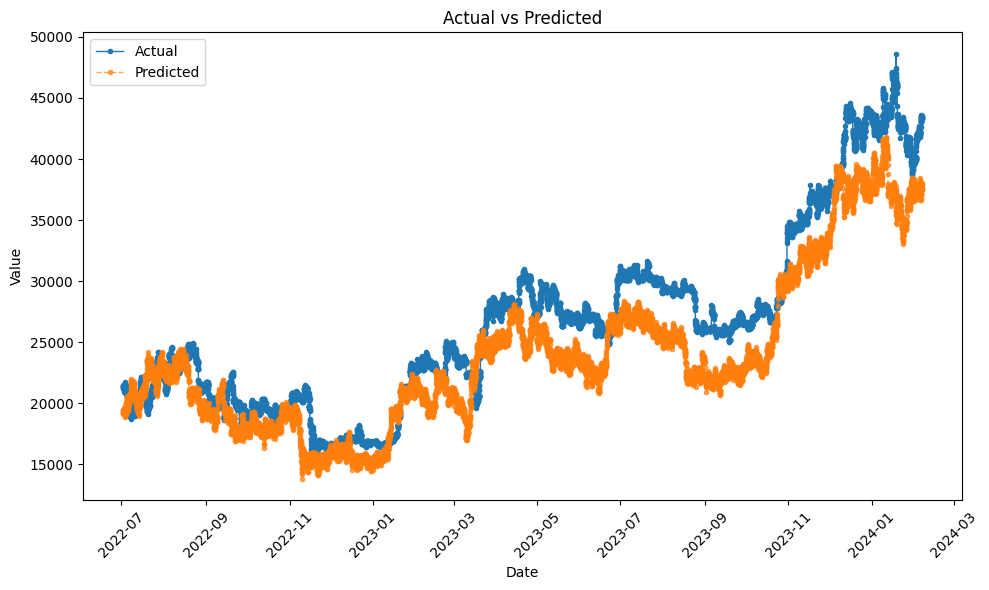

In [3]:
import matplotlib.pyplot as plt
y_test_original = y_test.values.flatten()[:len(y_pred)]  # Adjust length if necessary
# Assuming y_test_original and y_pred are correctly aligned with these dates
test_dates_aligned = X_test['datetime'].values[-len(y_pred):]

plt.figure(figsize=(10, 6))
plt.plot(test_dates_aligned, y_test_original, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(test_dates_aligned, y_pred, label='Predicted', alpha=0.7, marker='.', linestyle='--', linewidth=1)
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Improve readability of the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
